<a href="https://colab.research.google.com/github/daniel-usp/Python/blob/main/Paper_Pair_Trading_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pycop
import pandas as pd
import numpy as np






Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pycop import empirical
from itertools import combinations

# Replace the tickers with the actual tickers of the 25 most heavily traded stocks
tickers = ['PETR3.SA', 'PETR4.SA', 'ITUB4.SA', 'VIIA3.SA', 'MGLU3.SA','CSNA3.SA','GGBR4.SA']

start_date = datetime(2020, 3, 31)
end_date = datetime(2023, 3, 31)

# Download historical data
data = yf.download(tickers, start=start_date, end=end_date, group_by = 'ticker')

# Compute log-returns
log_returns = {}
log_prices = {}
prices = {}
for ticker in tickers:
    price = data[ticker]['Adj Close']
    log_prices[ticker] = np.log(price).dropna()
    log_returns[ticker] = np.log(price / price.shift(1)).dropna()
    prices[ticker] = data[ticker]['Adj Close']

# Combine log-prices into a single DataFrame
log_prices_df = pd.DataFrame(log_prices)

# Combine log-returns into a single DataFrame
log_returns_df = pd.DataFrame(log_returns)
# Create a DataFrame with prices
precos = pd.DataFrame(prices)
precos


[*********************100%***********************]  7 of 7 completed


,PETR3.SA,PETR4.SA,ITUB4.SA,VIIA3.SA,MGLU3.SA,CSNA3.SA,GGBR4.SA
Date,,,,,,,
2020-03-31,6.135617,5.913946,20.874271,5.28,9.508197,5.449534,7.181519
2020-04-01,6.165992,6.044992,19.359013,4.65,9.139964,5.340232,6.838521
2020-04-02,6.695374,6.556491,19.449484,4.38,8.752224,5.441726,7.174373
2020-04-03,6.647642,6.484627,18.689590,4.10,8.666872,4.879598,6.667021
2020-04-06,7.007795,6.666401,20.064627,4.36,9.315546,5.113818,6.931416
...,...,...,...,...,...,...,...
2023-03-24,23.111320,20.283543,23.172091,1.87,3.230000,13.158474,24.076450
2023-03-27,23.462584,20.630650,23.571268,1.93,3.340000,13.234921,24.164570
2023-03-28,23.867887,20.995558,23.681038,1.94,3.380000,13.779607,24.252691


In [ ]:
#Calculate Tail Dependence
def calculate_utd_ltd(ticker1, ticker2, window_data):
    cop = empirical(window_data[[ticker1, ticker2]])
    utd = cop.optimal_tdc("upper")
    ltd = cop.optimal_tdc("lower")
    return utd, ltd

# definindo as datas de início e fim
start_date = datetime(2022, 11, 1)
end_date = datetime(2023, 3, 31)

# definindo a janela móvel
window_size = 90

# criando uma lista com todos os pares de ativos nos tickers
pairs = list(combinations(tickers, 2))

# criando os dicionários para armazenar os resultados de UTD e LTD
utd_dict = {pair: [] for pair in pairs}
ltd_dict = {pair: [] for pair in pairs}

# percorrendo todos os pares de ativos e calculando UTD e LTD para cada um
for pair in pairs:
    ticker1 = pair[0]
    ticker2 = pair[1]
    window = start_date + timedelta(days = window_size)
    while window <= end_date:
        end = window.strftime('%Y-%m-%d')
        start = (window - timedelta(days=window_size)).strftime('%Y-%m-%d')
        # selecionando os dados para a janela móvel
        window_data = log_returns_df.loc[start:end, [ticker1, ticker2]]

        # calculando UTD e LTD para o par de ativos
        utd, ltd = calculate_utd_ltd(ticker1, ticker2, window_data)
        # armazenando os resultados nas listas dentro dos dicionários
        utd_dict[pair].append(utd)
        ltd_dict[pair].append(ltd)
        window += timedelta(days = 1)


<Axes: >

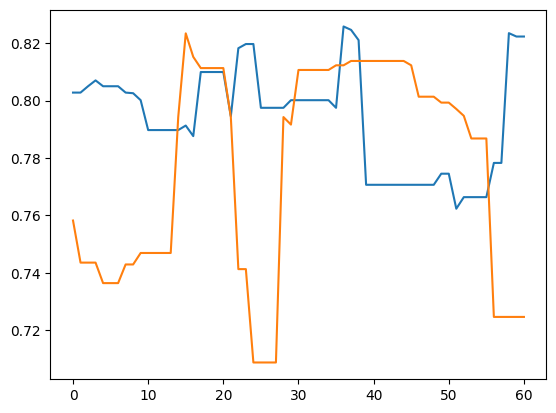

In [ ]:
pd.Series(ltd_dict[('PETR3.SA','PETR4.SA')]).plot()
pd.Series(utd_dict[('PETR3.SA','PETR4.SA')]).plot()


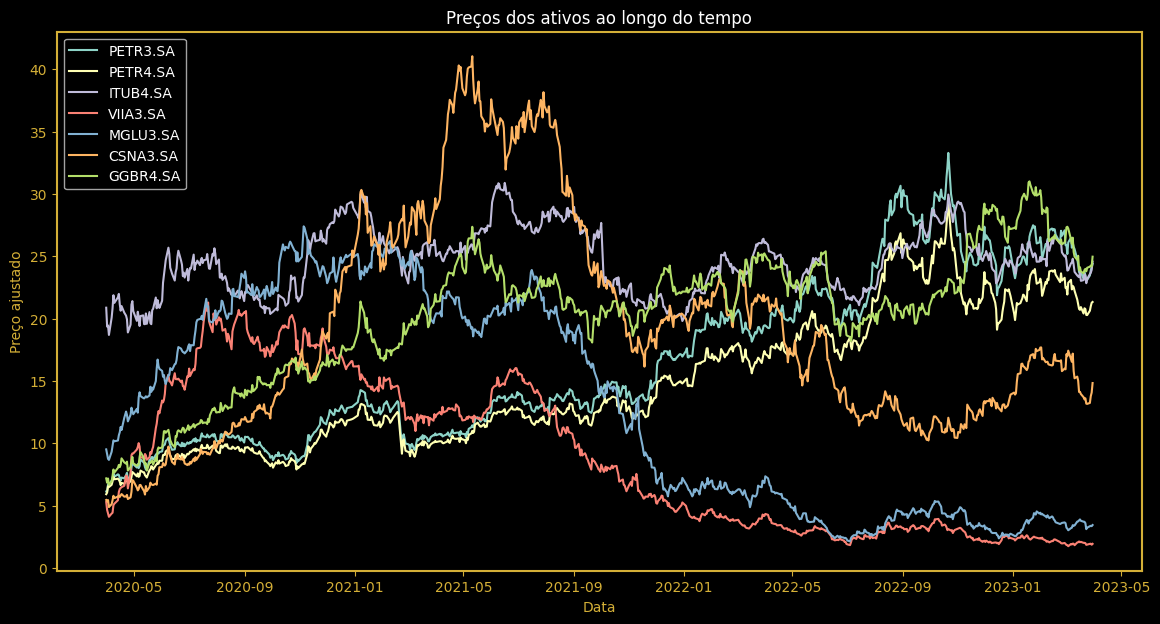

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def plot_prices(prices_df):
    plt.figure(figsize=(14, 7))

    # Ajustar as cores dos eixos e labels para dourado
    plt.rcParams['axes.edgecolor'] = '#d4af37'
    plt.rcParams['axes.labelcolor'] = '#d4af37'
    plt.rcParams['xtick.color'] = '#d4af37'
    plt.rcParams['ytick.color'] = '#d4af37'

    # Ajustar a espessura dos eixos
    plt.rcParams['axes.linewidth'] = 1.5

    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    for ticker in prices_df.columns:
        plt.plot(prices_df.index, prices_df[ticker], label=ticker)

    plt.xlabel('Data')
    plt.ylabel('Preço ajustado')
    plt.title('Preços dos ativos ao longo do tempo')
    plt.legend()
    plt.show()

plot_prices(precos)



In [ ]:
#Pair Cointegration
import itertools
from statsmodels.tsa.stattools import coint
import numpy as np

def find_cointegrated_pairs(log_returns_df, significance=0.05):
    n = log_returns_df.shape[1]
    keys = log_returns_df.keys()
    cointegrated_pairs = []
    cointegrated_pairs_pvalue = []

    for pair in itertools.combinations(keys, 2):
        asset1, asset2 = pair
        _, p_value, _ = coint(log_returns_df[asset1], log_returns_df[asset2],maxlag = 1)

        if p_value < significance:
            cointegrated_pairs_pvalue.append((asset1, asset2, p_value))
            cointegrated_pairs.append((asset1, asset2))

    return cointegrated_pairs, cointegrated_pairs_pvalue

cointegrated_pairs = find_cointegrated_pairs(precos)[0]
cointegrated_pairs




[('PETR3.SA', 'PETR4.SA'),
 ('PETR3.SA', 'VIIA3.SA'),
 ('PETR3.SA', 'MGLU3.SA'),
 ('PETR4.SA', 'VIIA3.SA'),
 ('PETR4.SA', 'MGLU3.SA')]

In [ ]:
import statsmodels.api as sm

def get_cointegration_spreads(log_returns_df, cointegrated_pairs):
  spreads = {}

  for pair in cointegrated_pairs:
    asset1, asset2 = pair
    x = log_returns_df[asset1]
    y = log_returns_df[asset2]

    # Fit a linear regression
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()

    # Store the residuals
    spread = y - model.params[0] - model.params[1]*x.iloc[:,1]
    spreads[f"{asset1}_{asset2}"] = spread

  return spreads

spreads = pd.DataFrame(get_cointegration_spreads(precos, cointegrated_pairs))
spreads_dict =dict(spreads)

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
normalized_spreads = scaler.fit_transform(spreads)

# Convert the normalized spreads to a DataFrame
normalized_spreads_df = pd.DataFrame(normalized_spreads, columns=spreads.columns, index = precos.index)
normalized_spreads_df





,PETR3.SA_PETR4.SA,PETR3.SA_VIIA3.SA,PETR3.SA_MGLU3.SA,PETR4.SA_VIIA3.SA,PETR4.SA_MGLU3.SA
Date,,,,,
2020-03-31,-0.723370,-3.093341,-3.046909,-3.055000,-2.951488
2020-04-01,-0.299285,-3.258553,-3.117567,-3.192468,-2.993157
2020-04-02,-0.017381,-3.225250,-3.081497,-3.144509,-2.942508
2020-04-03,-0.146060,-3.311023,-3.110040,-3.236144,-2.978040
2020-04-06,-0.620958,-3.167700,-2.893697,-3.124052,-2.800213
...,...,...,...,...,...
2023-03-24,0.163444,-0.598135,-0.596358,-0.592815,-0.590801
2023-03-27,0.381422,-0.510997,-0.495222,-0.495323,-0.480603
2023-03-28,0.490142,-0.426561,-0.396797,-0.407004,-0.380126


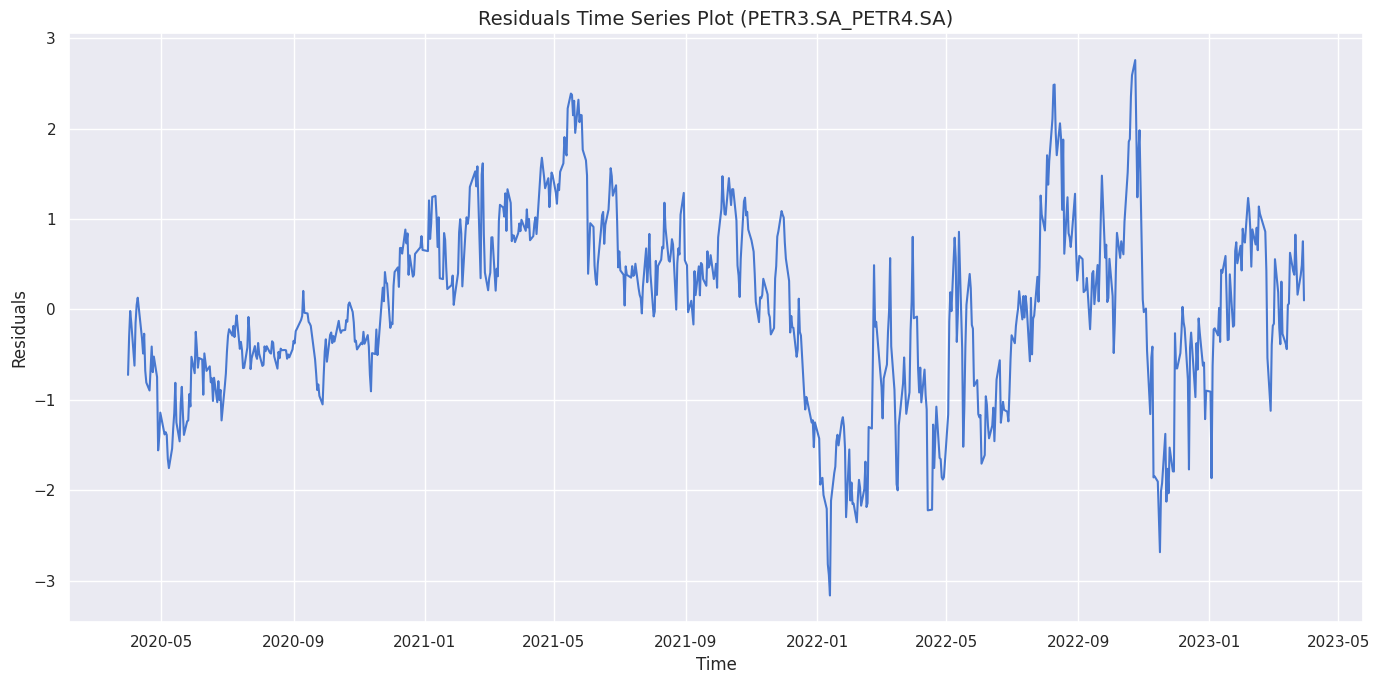

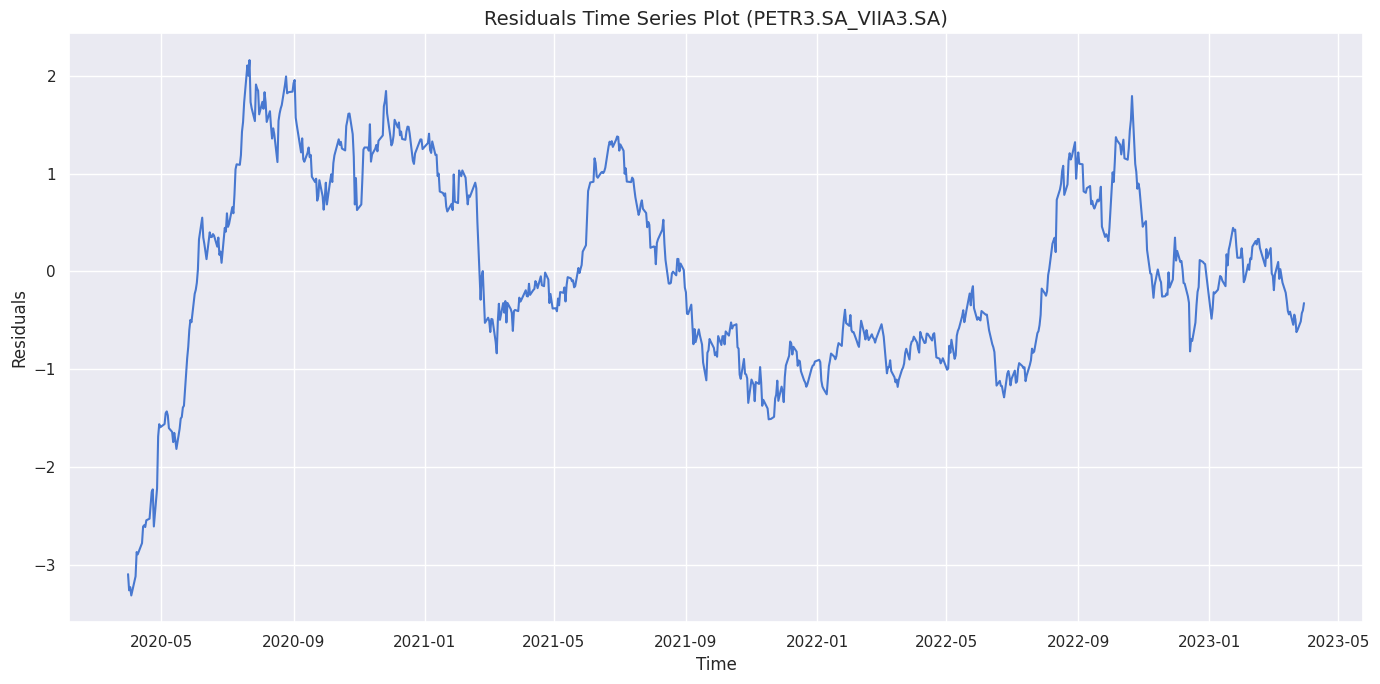

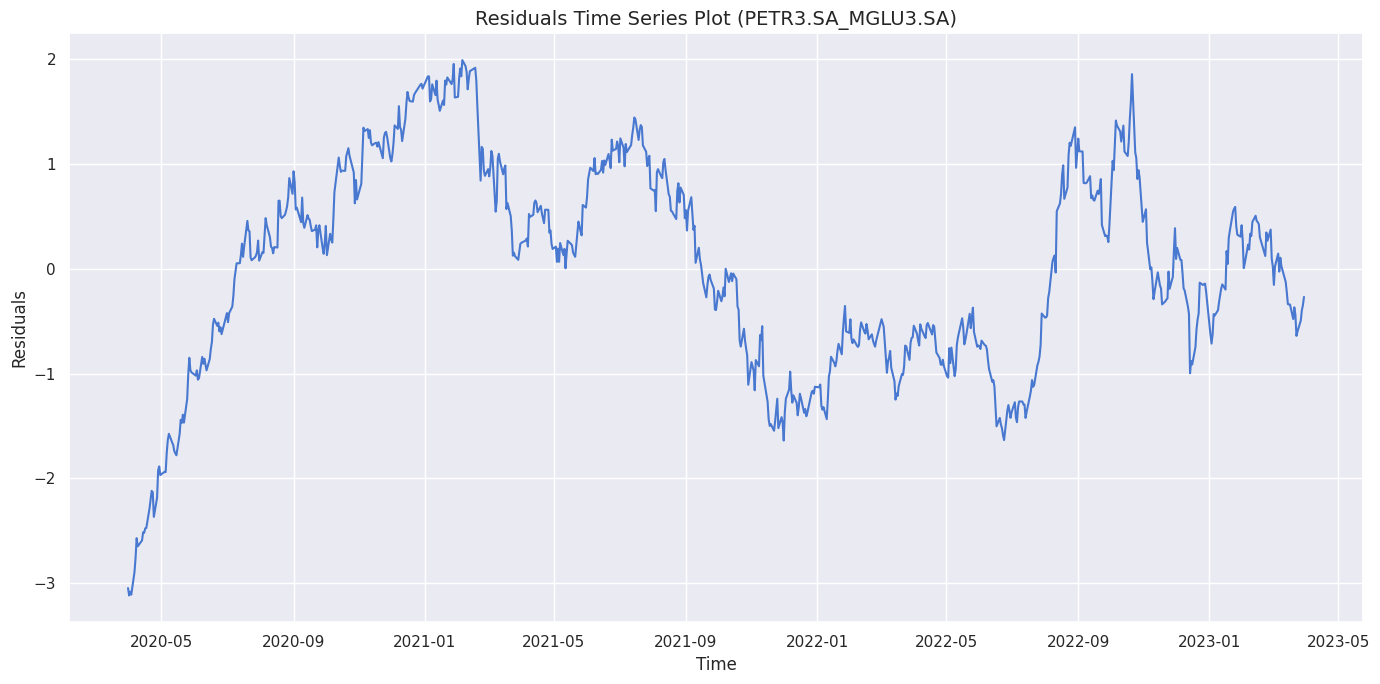

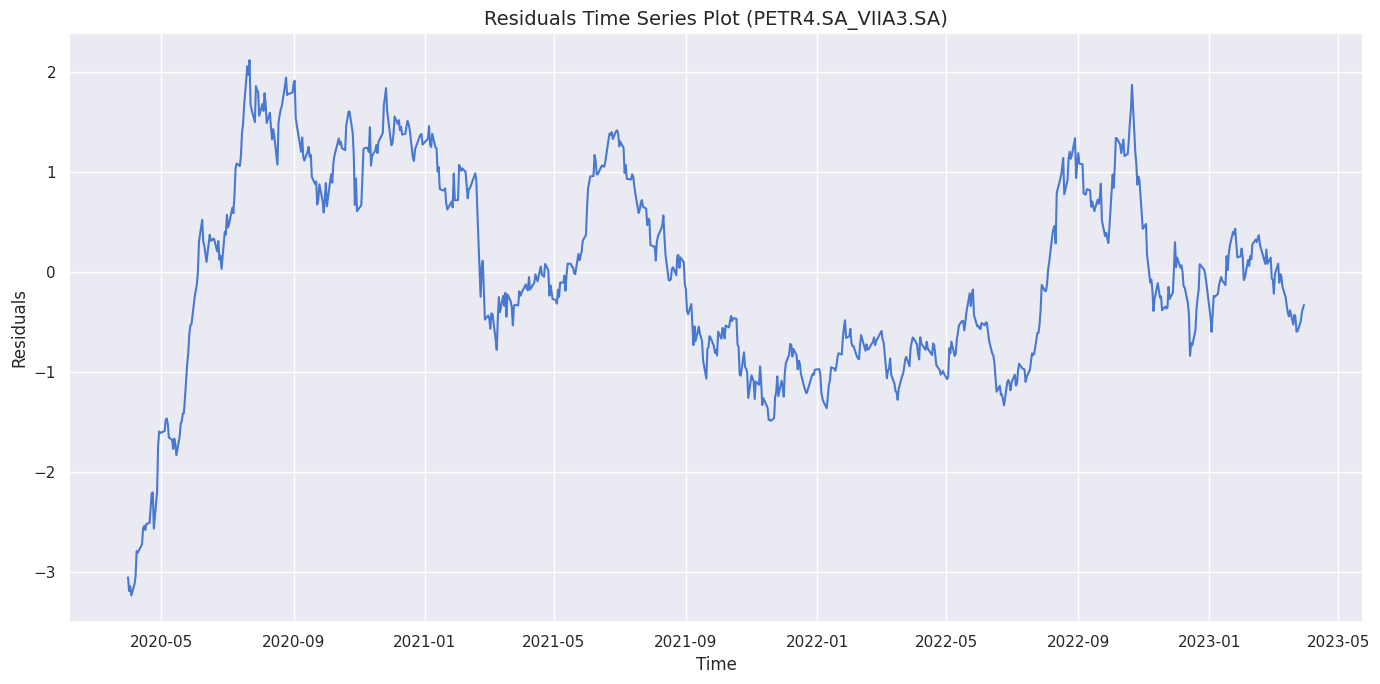

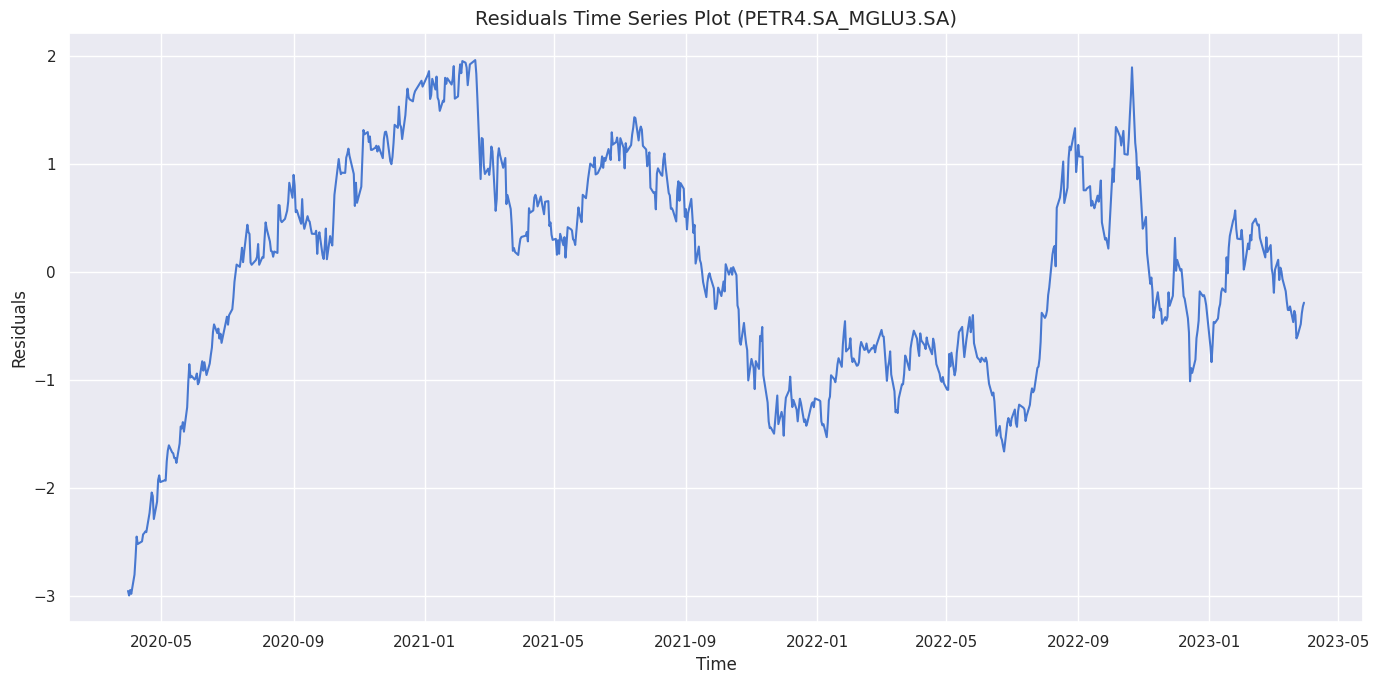

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and color palette
sns.set(style="darkgrid", palette="muted")

# Loop through all columns of normalized_spreads_df and plot each one
for col in normalized_spreads_df.columns:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=normalized_spreads_df[col])
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.title(f'Residuals Time Series Plot ({col})', fontsize=14)
    plt.tight_layout()
    plt.show()





In [ ]:
#Lista de tickers únicos dos pares cointegrados
unique_tickers = set()
for pair in cointegrated_pairs:
    unique_tickers.update(pair)

unique_tickers = list(unique_tickers)
unique_tickers


['PETR4.SA', 'MGLU3.SA', 'PETR3.SA', 'VIIA3.SA']

In [ ]:
import yfinance as yf
!pip install ta
import ta
!pip install pandas_ta
import pandas_ta as techind
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator


start_date = '2018-02-27'
end_date = '2023-02-28'

technical_indicators_for_trend = {}
technical_indicators_for_momentum = {}
technical_indicators_for_volume = {}
technical_indicators_for_rs = {}
technical_indicators_for_mr = {}

# Loop through unique tickers and calculate technical indicators
for ticker in unique_tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate technical indicators for trend
    ma = ta.trend.SMAIndicator(data['Close'], window=50).sma_indicator()
    # Calculate Exponential Moving Average (EMA)
    ema = ta.trend.EMAIndicator(data['Close'], window=50).ema_indicator()
    # Calculate Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close']).macd()
    # Calculate Average Directional Index (ADX)
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close']).adx()
    # Store technical indicators in dictionary for trend
    technical_indicators_for_trend[ticker] = {'MA': ma, 'EMA': ema, 'MACD': macd, 'ADX': adx,                                 }

    # Calculate technical indicators for momentum
    # Calculate Relative Strength Index (RSI)
    rsi = ta.momentum.RSIIndicator(data['Close']).rsi()
    # Calculate Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close']).macd()
    # Calculate ROC Momentum (10)
    roc_10 = ROCIndicator(data['Close'], window=10).roc()
    # Calculate ROC Momentum (10)
    roc_14 = ROCIndicator(data['Close'], window=14).roc()
    # Store technical indicators in dictionary for momentum
    technical_indicators_for_momentum[ticker] = {'RSI': rsi, 'ROC10': roc_10, 'MACD': macd, 'ROC14': roc_14}

    # Calculate technical indicators for volume
    # Calculate On-Balance Volume (OBV)
    obv = ta.volume.OnBalanceVolumeIndicator(data['Close'], data['Volume']).on_balance_volume()
    # Calculate Money Flow Index (MFI)
    mfi = ta.volume.MFIIndicator(data['High'], data['Low'], data['Close'], data['Volume']).money_flow_index()
    # Store technical indicators in dictionary for volume
    technical_indicators_for_volume[ticker] = {'OBV': obv, 'MFI': mfi}

    # Calculate technical indicators for Relative Strength
    # Calculate Relative Strength (RSI)
    rsi = RSIIndicator(data['Close'], window=14).rsi()
    # Crie um objeto WilliamsRIndicator com os preços 'High', 'Low', e 'Close' e o período desejado (por exemplo, 14)
    williams = ta.momentum.WilliamsRIndicator(data['High'], data['Low'], data['Close']).williams_r()

    # Store technical indicators in dictionary for relative strength
    technical_indicators_for_rs[ticker] = {'RSI': rsi, 'Williams': williams}

    # Calculate the Mean Reversion
    # Calculate Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close']).stoch()







Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=89b7254b83fbcb8126eac0a39a584b523a11c7950d09cbe7f456b0a7a979afd1
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=d86a73b0cd914b11f7f26539ce23a344b390201975328efef60c4bd965bf006d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
[*********************100%***********************]  1 of 1 completed
[*

In [ ]:
#PCA for Technical Indicators
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize dictionary to store PCA results
technical_indicators_trend_pca = {}

# Loop through unique tickers and run PCA on trend indicators
for ticker in unique_tickers:
    # Extract trend indicators for the ticker
    indicators = technical_indicators_for_trend[ticker]

    # Convert indicators to DataFrame
    df = pd.DataFrame(indicators).dropna()

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Run PCA with n_components=1
    pca = PCA(n_components=1)
    pca.fit(df_scaled)
    pca_result = pca.transform(df_scaled)

    # Store PCA result in dictionary
    technical_indicators_trend_pca[ticker] = pd.DataFrame(pca_result.flatten(), index=df.index, columns=[f'Trend_{ticker}'])




In [ ]:
#PCA for Technical Indicators for Momentum
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize dictionary to store PCA results
technical_indicators_momentum_pca = {}

# Loop through unique tickers and run PCA on trend indicators
for ticker in unique_tickers:
    # Extract trend indicators for the ticker
    indicators = technical_indicators_for_momentum[ticker]

    # Convert indicators to DataFrame
    df = pd.DataFrame(indicators).dropna()

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Run PCA with n_components=1
    pca = PCA(n_components=1)
    pca.fit(df_scaled)
    pca_result = pca.transform(df_scaled)

    # Store PCA result in dictionary
    technical_indicators_momentum_pca[ticker] = pd.DataFrame(pca_result.flatten(), index=df.index, columns=[f'Momentum_{ticker}'])



In [ ]:
#PCA for Technical Indicators for Volume
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize dictionary to store PCA results
technical_indicators_volume_pca = {}

# Loop through unique tickers and run PCA on trend indicators
for ticker in unique_tickers:
    # Extract trend indicators for the ticker
    indicators = technical_indicators_for_volume[ticker]

    # Convert indicators to DataFrame
    df = pd.DataFrame(indicators).dropna()

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Run PCA with n_components=1
    pca = PCA(n_components=1)
    pca.fit(df_scaled)
    pca_result = pca.transform(df_scaled)

    # Store PCA result in dictionary
    technical_indicators_volume_pca[ticker] = pd.DataFrame(pca_result.flatten(), index=df.index, columns=[f'Volume_{ticker}'])


In [ ]:
#PCA for Technical Indicators for Relative Strength
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize dictionary to store PCA results
technical_indicators_rs_pca = {}

# Loop through unique tickers and run PCA on trend indicators
for ticker in unique_tickers:
    # Extract trend indicators for the ticker
    indicators = technical_indicators_for_rs[ticker]

    # Convert indicators to DataFrame
    df = pd.DataFrame(indicators).dropna()

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Run PCA with n_components=1
    pca = PCA(n_components=1)
    pca.fit(df_scaled)
    pca_result = pca.transform(df_scaled)

    # Store PCA result in dictionary
    technical_indicators_rs_pca[ticker] = pd.DataFrame(pca_result.flatten(), index=df.index, columns=[f'RS_{ticker}'])

In [ ]:
technical_indicators_rs_pca['MGLU3.SA']

,RS_MGLU3.SA
Date,
2018-03-16,-0.734997
2018-03-19,0.055167
2018-03-20,0.400333
2018-03-21,-1.065812
2018-03-22,-1.499087
...,...
2023-02-17,1.634524
2023-02-22,1.721809
2023-02-23,1.563145


In [ ]:
pip install aiohttp asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import urllib.request
import requests
from datetime import datetime, timedelta
import pandas as pd
import nest_asyncio
import asyncio
import time

nest_asyncio.apply()

apikey = "31b387df22c35bf1fbb0b0c5fe44d055"
tickers = ["PETR4","VALE3.SA"]
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 3, 31)

async def fetch(session, url):
    async with session.get(url) as response:
        return await response.text()

async def main(loop, ticker, start_date, end_date):
    month_polarity = []
    aux = []

    while start_date <= end_date:
        year = start_date.year
        month = start_date.month
        start = start_date.strftime('%Y-%m-%d')
        end = (start_date + timedelta(days=30)).strftime('%Y-%m-%d')

        url = f"https://gnews.io/api/v4/search?q={ticker}&lang=pt&country=br&max=10&apikey={apikey}&from={start}T11:30:00Z&to={end}T17:59:00Z"

        with urllib.request.urlopen(url) as response:
            data = json.loads(response.read().decode("utf-8"))
            articles = data["articles"]

        # Cálculo da Análise de Sentimento pelo Sentic Net API
        async with aiohttp.ClientSession() as session:
            tasks = [fetch(session, f"http://sentic.net/api/pt/acV1n7ezQse6.py?fin=1&br=1&lang=pt&text={a['description']} {a['title']}") for a in articles]
            responses = await asyncio.gather(*tasks)
            for r in responses:
                polarity_value = json.loads(r)
                aux.append(polarity_value)

        month_polarity.append(pd.Series(aux).median())
        start_date += timedelta(days=30)  # atualiza o valor de start_date

    return {ticker: month_polarity}

loop = asyncio.get_event_loop()
tasks = [main(loop, ticker, start_date, end_date) for ticker in tickers]
results = loop.run_until_complete(asyncio.gather(*tasks))
polarity = {k: v for result in results for k, v in result.items()}
print(polarity)


HTTPError: ignored

In [ ]:
import aiohttp
import asyncio
import json
import pandas as pd
import time
from datetime import datetime, timedelta

apikey = "31b387df22c35bf1fbb0b0c5fe44d055"
tickers = ["PETR4","VALE3"]
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 3, 31)

async def get_articles(session, ticker, start, end):
    url = f"https://gnews.io/api/v4/search?q={ticker}&lang=pt&country=br&max=10&apikey={apikey}&from={start}T11:30:00Z&to={end}T17:59:00Z"
    async with session.get(url) as response:
        data = await response.json()
        articles = data["articles"]
    return articles

async def get_polarity(session, article):
    input_text = f"{article['description']} {article['title']}"
    url = f"http://sentic.net/api/pt/acV1n7ezQse6.py?fin=1&br=1&lang=pt&text={input_text}"
    async with session.get(url) as response:
        polarity_value = await response.text()
    return json.loads(polarity_value)

async def main(start_date, end_date):
    polarity = {}
    async with aiohttp.ClientSession() as session:
        for ticker in tickers:
            month_polarity = []
            for i in range((end_date - start_date).days + 1):
                curr_date = start_date + timedelta(days=i)
                start = curr_date.strftime('%Y-%m-%d')
                end = (curr_date + timedelta(days=1)).strftime('%Y-%m-%d')

                articles = await get_articles(session, ticker, start, end)
                polarities = await asyncio.gather(*(get_polarity(session, article) for article in articles))

                month_polarity.append(pd.Series(polarities).median())
            polarity[ticker] = month_polarity
    return polarity

start = time.time()
polarity = asyncio.run(main(start_date, end_date))
end = time.time()
print(polarity)
print(f"Time elapsed: {end - start:.2f} seconds")


JSONDecodeError: ignored

In [ ]:
import urllib.request
import requests
from datetime import datetime, timedelta
import pandas as pd
import json
import time

apikey = "31b387df22c35bf1fbb0b0c5fe44d055"
tickers = ["Budweiser"]
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 3, 31)

def fetch(url):
    with urllib.request.urlopen(url) as response:
        data = json.loads(response.read().decode("utf-8"))
        articles = data["articles"]
    return articles

def get_polarity(articles):
    polarity_values = []
    for a in articles:
        url = f"http://sentic.net/api/en/acV1n7ezQse6.py?fin=1&us=1&lang=pt&text={a['description']} {a['title']}"
        with urllib.request.urlopen(url) as response:
            polarity_value = json.loads(response.read().decode("utf-8"))
            polarity_values.append(polarity_value)
    return pd.Series(polarity_values).median()

def main(ticker, start_date, end_date):
    month_polarity = []
    while start_date <= end_date:
        year = start_date.year
        month = start_date.month
        start = start_date.strftime('%Y-%m-%d')
        end = (start_date + timedelta(days=30)).strftime('%Y-%m-%d')

        url = f"https://gnews.io/api/v4/search?q={ticker}&lang=en&country=us&max=10&apikey={apikey}&from={start}T11:30:00Z&to={end}T17:59:00Z"

        articles = fetch(url)
        polarity_value = get_polarity(articles)
        month_polarity.append(polarity_value)
        start_date += timedelta(days=30)  # atualiza o valor de start_date

    return {ticker: month_polarity}

polarity = {}
for ticker in tickers:
    result = main(ticker, start_date, end_date)
    polarity.update(result)

print(polarity)